# Monte Carlo Droupout Model

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [2]:
print('Reading data')
trn = pd.read_hdf('train.h5')
val = pd.read_hdf('validation.h5')
tst = pd.read_hdf('test.h5')

val = val.sample(frac=1).reset_index(drop=True)
tst = tst.sample(frac=1).reset_index(drop=True)

max_sequence_length = 8000

# sequences to list of integers
print('Splitting events')
trn['Events_removed'] = trn['Events_removed'].apply(lambda x: [int(e) for e in x.split(',')[:max_sequence_length]])
val['Events_removed'] = val['Events_removed'].apply(lambda x: [int(e) for e in x.split(',')[:max_sequence_length]])
tst['Events_removed'] = tst['Events_removed'].apply(lambda x: [int(e) for e in x.split(',')[:max_sequence_length]])

# Padding sequences to ensure uniform length
X = pad_sequences(trn['Events_removed'], maxlen=max_sequence_length)
V = pad_sequences(val['Events_removed'], maxlen=max_sequence_length)
T = pad_sequences(tst['Events_removed'], maxlen=max_sequence_length)


Reading data
Splitting events


In [3]:
X_train, y_train= X, trn['Onsite']
X_val, y_val= V, val['Onsite']
X_test, y_test = T, tst['Onsite']

### Define model architecture, train, test, and predict functions 

In [4]:
def get_model():
    """
    Define and compile the Monte Carlo Dropout model.
    
    The model architecture consists of several Dense layers with ReLU activation along with dropouts,
    followed by a final Dense layer with sigmoid activation for binary classification.
    
    Returns:
        tf.keras.Sequential: Compiled Monte Carlo Dropout model.
    """ 
    
    model = Sequential([
    Flatten(input_shape=(8000,1)),
    Dense(8192, activation='relu'),
    Dropout(.1),
    Dense(4096, activation='relu'),
        Dropout(.1),
    Dense(2048, activation='relu'),
        Dropout(.1),
    Dense(1024, activation='relu'),
        Dropout(.1),
    Dense(512, activation='relu'),
        Dropout(.1),
    Dense(256, activation='relu'),
        Dropout(.1),
    Dense(128, activation='relu'),
        Dropout(.1),
    Dense(64, activation='relu'),
        Dropout(.1),
    Dense(32, activation='relu'),
        Dropout(.1),
        Dense(1, activation='sigmoid')
    ])
    optim = tf.keras.optimizers.Adam(1e-3)
    model.compile(optimizer=optim, metrics=['accuracy'], loss=BinaryCrossentropy())
    return model


In [5]:
def train(x, y, model, x_val, y_val, epochs=1000):
    """
    Train the Monte Carlo Dropout model with early stopping.
    
    Parameters:
        x (numpy.ndarray): Input features for training.
        y (numpy.ndarray): Target labels for training.
        model (tf.keras.Sequential): Compiled Monte Carlo Dropout model.
        x_val (numpy.ndarray): Input features for validation.
        y_val (numpy.ndarray): Target labels for validation.
        epochs (int): Number of epochs for training.
        
    Returns:
        tf.keras.Sequential: Trained Monte Carlo Dropout model.
    """
    
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, mode='min', patience=5, verbose=1, restore_best_weights=True)
    model.fit(x, y, epochs=epochs, validation_data=(x_val, y_val), callbacks=[es])
    return model

In [6]:
def test(x_test, y_test, model):
    """
    Test the Monte Carlo Dropout model and calculate accuracy and uncertainty.
    
    Parameters:
        x_test (numpy.ndarray): Input features for testing.
        y_test (numpy.ndarray): Target labels for testing.
        model (tf.keras.Sequential): Trained Monte Carlo Dropout model.
        
    Returns:
        list: List of predicted probabilities.
        list: List of standard deviations.
    """
    
    probabilities = []
    sd_list = []
    correct_predictions = 0
    uncertain_predictions = 0

    for i in range(len(x_test)):
        x_sample = x_test[i:i+1]
        y_true = y_test.iloc[i]

        probs, sd = predict(model, x_sample)
        probabilities.append(probs[0][0])
        sd_list.append(sd)
        
        # Classify predictions
        predicted_class = 1 if probs[0][0] > 0.6 else 0 if probs[0][0] < 0.5 else 0.5

        # Count uncertain predictions
        if predicted_class == 0.5:
            uncertain_predictions += 1
            continue

        # Count correct predictions
        if predicted_class == y_true:
            correct_predictions += 1
        
    # Calculate accuracy
    accuracy = correct_predictions / (len(x_test) - uncertain_predictions)
    print('Probabiity Range Accuracy:', accuracy)
    
    # Calculate uncertainty
    uncertainity = uncertain_predictions / len(x_test)
    print('Probabiity Range Uncertainity: ', uncertainity)
    
    return probabilities, sd_list


In [7]:
def predict(model, x, samples=20):
    """
    Make predictions and calculate standard deviation.
    
    Parameters:
        model (tf.keras.Sequential): Trained Monte Carlo Dropout model.
        x (numpy.ndarray): Input features for prediction.
        samples (int): Number of times each data point is predicted to estimate uncertainty.
        
    Returns:
        numpy.ndarray: Predicted probabilities.
        float: Standard deviation.
    """
    
    yhat_arr = []

    for t in range(samples):
        yhat = model(x, training=True)
        yhat_arr.append(yhat)

    yhat_arr = np.array(yhat_arr)
    probs = np.mean(yhat_arr, axis=0)
    sd = np.std(yhat_arr)
    return probs, sd

### Train the model

In [8]:
model = get_model()

model = train(x=X_train, y=y_train, model=model, x_val=X_val, y_val=y_val)

Epoch 1/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.4986 - loss: 728.6050 - val_accuracy: 0.5696 - val_loss: 0.6870
Epoch 2/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.4951 - loss: 0.9395 - val_accuracy: 0.5236 - val_loss: 0.7003
Epoch 3/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5241 - loss: 0.8292 - val_accuracy: 0.5675 - val_loss: 0.6897
Epoch 4/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.5212 - loss: 0.7240 - val_accuracy: 0.5717 - val_loss: 0.6814
Epoch 5/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5052 - loss: 0.7489 - val_accuracy: 0.5707 - val_loss: 0.6881
Epoch 6/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.5298 - loss: 0.7396 - val_accuracy: 0.5707 - val_loss: 0.6926
Epoch 7/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.5658 - loss: 0.7115 - val_accuracy: 0.4293 - val_loss: 0.8755
Epoch 8/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.5490 - loss: 0.7270 - val_ac

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 8000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8192)                │      65,544,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      33,558,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2048)                │       8,390,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 330,872,837 (1.23 GB)

 Trainable params: 110,290,945 (420.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 220,581,892 (841.45 MB)

###  Model Validation

In [10]:
print("Validation")
probabilities, sd_list = test(X_val,y_val,model)
print("Standard Deviation: ", np.mean(sd_list)) 
print("Probability: ", np.mean(probabilities))

Validation
Probabiity Range Accuracy: 0.5045164705882353
Probabiity Range Uncertainty: 0.745339443254818
Standard Deviation:  0.13001882
Probability:  0.55698425


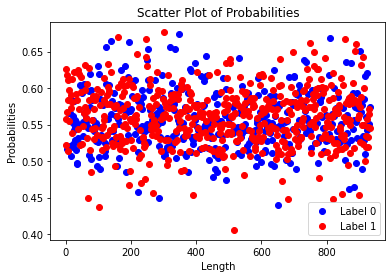

In [12]:
# Separate data points based on their true labels
points_label_0 = [(length, prob) for length, prob, label in zip(range(len(probabilities)), probabilities, y_val) if label == 0]
points_label_1 = [(length, prob) for length, prob, label in zip(range(len(probabilities)), probabilities, y_val) if label == 1]

# Extract x and y values for the scatter plot
x_label_0, y_label_0 = zip(*points_label_0)
x_label_1, y_label_1 = zip(*points_label_1)

plt.scatter(x_label_0, y_label_0, c='blue', label='Label 0')
plt.scatter(x_label_1, y_label_1, c='red', label='Label 1')
plt.title('Scatter Plot of Probabilities')
plt.xlabel('Length')
plt.ylabel('Probabilities')
plt.legend()
plt.show()

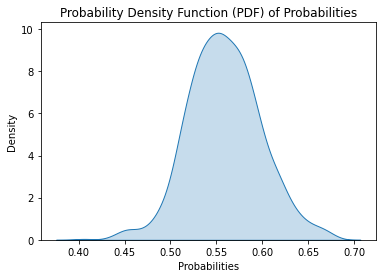

In [13]:
sns.kdeplot(probabilities, fill=True)
plt.title('Probability Density Function (PDF) of Probabilities')
plt.xlabel('Probabilities')
plt.ylabel('Density')
plt.show()

In [14]:
correct_prediction = 0 
uncertain_prediction = 0

standard_deviation = np.mean(sd_list) / 2

total_data_points = len(y_val)

for i in range(total_data_points):
    prob = probabilities[i]
    
    # Define lower and upper bounds based on standard deviation
    lb = prob - standard_deviation
    ub = prob + standard_deviation
    
    # Classify predictions
    c = 1 if lb > 0.55 else 0 if ub < 0.55 else 0.5
    
    # Count uncertain predictions
    if c == 0.5:
        uncertain_prediction += 1
        continue
    
    # Count correct predictions
    if c == y_test.iloc[i]:
        correct_prediction += 1


In [15]:
print("Validation SD Accuracy: ", correct_prediction/(total_data_points - uncertain_prediction))
print("Validation SD Uncertainity", uncertain_prediction/total_data_points)

Validation SD Accuracy:  0.5
Validation SD Uncertainity 0.9304734475374732


### Model Testing

In [16]:
print("Testing")
probabilities, sd_list = test(X_test,y_test,model)
print("Standard Deviation: ", np.mean(sd_list))
print("Probability: ", np.mean(probabilities))

Testing
Probabiity Range Accuracy: 0.5566492537313433
Probabiity Range Uncertainty: 0.7445492537313433
Standard Deviation:  0.12904269
Probability:  0.5580607


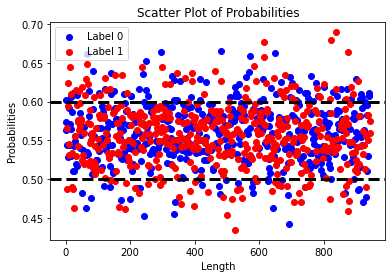

In [18]:
# Separate data points based on their true labels
points_label_0 = [(length, prob) for length, prob, label in zip(range(len(probabilities)), probabilities, y_test) if label == 0]
points_label_1 = [(length, prob) for length, prob, label in zip(range(len(probabilities)), probabilities, y_test) if label == 1]

# Extract x and y values for the scatter plot
x_label_0, y_label_0 = zip(*points_label_0)
x_label_1, y_label_1 = zip(*points_label_1)

plt.axhline(y=0.5, color='black', linestyle='--', linewidth=3)
plt.axhline(y=0.6, color='black', linestyle='--', linewidth=3)
plt.scatter(x_label_0, y_label_0, c='blue', label='Label 0')
plt.scatter(x_label_1, y_label_1, c='red', label='Label 1')
plt.title('Scatter Plot of Probabilities')
plt.xlabel('Length')
plt.ylabel('Probabilities')
plt.legend()
plt.show()

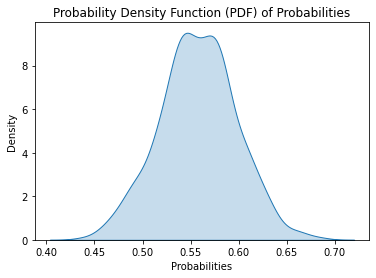

In [19]:
sns.kdeplot(probabilities, fill=True)
plt.title('Probability Density Function (PDF) of Probabilities')
plt.xlabel('Probabilities')
plt.ylabel('Density')
plt.show()

In [20]:
correct_prediction = 0 
uncertain_prediction = 0
standard_deviation =  0.13 / 2
total_data_points = len(y_test)

for i in range(total_data_points):
    prob = probabilities[i]
    
    # Define lower and upper bounds based on standard deviation
    lb = prob - standard_deviation
    ub = prob + standard_deviation
    
    # Classify predictions
    c = 1 if lb > 0.55 else 0 if ub < 0.55 else 0.5
    
    # Count uncertain predictions
    if c == 0.5:
        uncertain_prediction += 1
        continue
    
    # Count correct predictions
    if c == y_test.iloc[i]:
        correct_prediction += 1


In [21]:
print("Validation SD Accuracy: ", correct_prediction/(total_data_points - uncertain_prediction))
print("Validation SD Uncertainity", uncertain_prediction/total_data_points)

Validation SD Accuracy:  0.5072156942562585
Validation SD Uncertainity 0.9202347320813651
